The Herbarium 2021: Half-Earth Challenge is to identify vascular plant specimens provided by the New York Botanical Garden (NY), Bishop Museum (BPBM), Naturalis Biodiversity Center (NL), Queensland Herbarium (BRI), and Auckland War Memorial Museum (AK).

The Herbarium 2021: Half-Earth Challenge dataset includes more than 2.5M images representing nearly 65,000 species from the Americas and Oceania that have been aligned to a standardized plant list (LCVP v1.0.2).

## Disclaimer

This kernel is heavily inspired from [@yasufuminakama](https://www.kaggle.com/yasufuminakama)'s kernel from last year's competition [Herbarium 2020 PyTorch Resnet18 [train]](https://www.kaggle.com/yasufuminakama/herbarium-2020-pytorch-resnet18-train)

# Table of Content

1. [Packages 📦 and Basic Setup](#packages)
2. [🏷 Label Encoder](#label-encoder)
3. [💿 Dataset, DataLoader and K-Fold](#data)
4. [The Model 👷‍♀️](#Model)
5. [Training 💪🏻](#Training)

<a id = "packages"></a>
# Packages 📦 and Basic Setup

In the following **hidden** code cell, we: 

* Import the required libraries (Main ones being [`torch`](https://pytorch.org/), [`torchvision`](https://pytorch.org/vision/0.8/index.html) and [`sklearn`](https://scikit-learn.org/stable/index.html))
* Print the device configuration
* Set Random Seed 🌱 to ensure reproducibility
* Create a [Logger 📃](https://docs.python.org/3/library/logging.html) for Event Logging

In [1]:
%%capture
!pip install --upgrade wandb

In [2]:
# Import Statements
import os # To set Random Seed for Reproducibility
import cv2 # For Image 🌌 Processing
import json # For Reading in the JSON file
import torch # The Main Machine Learning Framework
import random # To set Random Seed for Reproducibility
import logging # For Event Logging
import sklearn # For LabelEncoder and Metrics
import torchvision # For creating a pretrained model
import numpy as np # For Numerical Processing
import pandas as pd # For creating DataFrames 
import albumentations # For Image Augmentations
from tqdm import tqdm # For Creating ProgressBar
from sklearn import preprocessing # For the 🏷 Label Encoder
from albumentations.pytorch import ToTensorV2 # For Converting to torch.Tensor
from sklearn.model_selection import StratifiedKFold # For Cross Validation


# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# Setting RandomSeed🌱 for Reproducibility 
def seed_torch(seed:int =42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch()

# Creating a logger 📃
def init_logger(log_file:str ='training.log'):
    
    # Specify the format 
    formatter = logging.Formatter('%(levelname)s:%(name)s:%(message)s')
    
    # Create a StreamHandler Instance
    stream_handler = logging.StreamHandler()
    stream_handler.setLevel(logging.DEBUG)
    stream_handler.setFormatter(formatter)
    
    # Create a FileHandler Instance
    file_handler = logging.FileHandler(log_file)
    file_handler.setFormatter(formatter)
    
    # Create a logging.Logger Instance
    logger = logging.getLogger('Herbarium')
    logger.setLevel(logging.DEBUG)
    logger.addHandler(stream_handler)
    logger.addHandler(file_handler)
    
    return logger

LOGGER = init_logger()
LOGGER.info("Logger Initialized")

# Logging Into Weights and Biases
import wandb
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("WANDB_API_KEY")
wandb.login(key=api_key);
LOGGER.info("Logged into Weights and Biases")
wandb.init(project='Herbarium 2021', entity='sauravmaheshkar')
LOGGER.info("New run Created")

INFO:Herbarium:Logger Initialized
wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
INFO:Herbarium:Logged into Weights and Biases
wandb: Currently logged in as: sauravmaheshkar (use `wandb login --relogin` to force relogin)


INFO:Herbarium:New run Created


In [3]:
# Basic Parameters for the Model
N_CLASSES = 64500
HEIGHT = 128
WIDTH = 128
batch_size = 512
n_epochs = 1
lr = 4e-4

In [4]:
%%time
with open('../input/herbarium-2021-fgvc8/train/metadata.json', "r", encoding="ISO-8859-1") as file:
    train = json.load(file)

train_img = pd.DataFrame(train['images'])
train_ann = pd.DataFrame(train['annotations']).drop(columns='image_id')
train_df = train_img.merge(train_ann, on='id')
LOGGER.info("Train DataFrame Created: ✅")
train_df.head()

INFO:Herbarium:Train DataFrame Created: ✅


CPU times: user 16.7 s, sys: 1.78 s, total: 18.5 s
Wall time: 21.5 s


,file_name,height,id,license,width,category_id,institution_id
0,images/604/92/1814367.jpg,1000,1814367,0,678,60492,0
1,images/108/24/1308257.jpg,1000,1308257,0,666,10824,0
2,images/330/76/1270453.jpg,1000,1270453,0,739,33076,3
3,images/247/99/1123834.jpg,1000,1123834,0,672,24799,0
4,images/170/18/1042410.jpg,1000,1042410,0,675,17018,0


As we can see the DataFrame contains the following columns:

* `file_name: str`: Contains the Relative Path to the Images
* `height: int`: The Height of the Image
* `width: int`: The Width of the Image
* `id: int`: The Image ID
* `license: int`: Either 0, 1 or 2
* `category_id: int`: Our **Target Variable** determining the species corresponding to the Image

In [5]:
train_df['category_id'].value_counts()

42811    3309
25229    2142
48372    2038
42843    1656
22344    1575
         ... 
62525       2
11297       2
58424       2
39154       2
2047        2
Name: category_id, Length: 64500, dtype: int64

array([[<AxesSubplot:title={'center':'category_id'}>]], dtype=object)

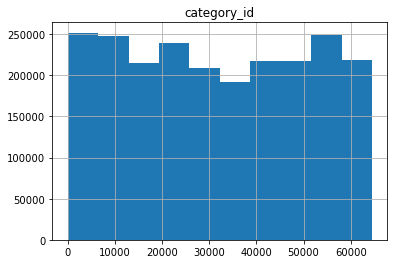

In [6]:
train_df.hist(column="category_id")

In [7]:
%%time
with open('../input/herbarium-2021-fgvc8/test/metadata.json', "r", encoding="ISO-8859-1") as file:
    test = json.load(file)

test_df = pd.DataFrame(test['images'])
LOGGER.info("Test DataFrame Created: ✅")
test_df.head()

INFO:Herbarium:Test DataFrame Created: ✅


CPU times: user 956 ms, sys: 64.1 ms, total: 1.02 s
Wall time: 1.27 s


,file_name,height,id,license,width
0,images/000/0.jpg,1000,0,0,680
1,images/000/1.jpg,1000,1,0,681
2,images/000/2.jpg,1000,2,0,676
3,images/000/3.jpg,1000,3,0,666
4,images/000/4.jpg,1000,4,0,676


<a id="label-encoder"></a>
# 🏷 Label Encoder

We use the [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) from sklearn.preprocessing in order to encode **target labels** with value between `0` and `n_classes-1`.

In [8]:
# Create a Instance of LabelEncoder
encoder = preprocessing.LabelEncoder()
LOGGER.info("LabelEncoder Instance created ✅")

# Fits the label encoder instance
LOGGER.info("Fitting the LabelEncoder Instance")
encoder.fit(train_df['category_id'])

# To Transform labels to normalized encoding
LOGGER.info("Converting Labels to Normalized Encoding")
train_df['category_id'] = encoder.transform(train_df['category_id'])

INFO:Herbarium:LabelEncoder Instance created ✅
INFO:Herbarium:Fitting the LabelEncoder Instance
INFO:Herbarium:Converting Labels to Normalized Encoding


<a id = "Data"></a>
# 💿 Dataset, DataLoader and K-Fold

The following code cell aims to convert the Herbarium dataset into a torch `torch..utils.data.Dataset` object.

All Dataset objects in pytorch represent a map from keys to data samples. We create a subclass which overwrites the __getitem__() and __len__() method (for it to work well with the `torch.utils.data.DataLoader`).

In the __getitem__() method, we use df[<column_name>].values[] to get the `file_name `and then use `cv2` to read the image. If the transform bool is set to True, we apply the transforms. 

Each element of our dataset returns:

* Image
* Encoded Label

In [9]:
class TrainDataset(torch.utils.data.Dataset):
    """
    Custom Dataset Class
    """
    def __init__(self, df, labels, transform=None):
        self.df = df
        self.labels = labels
        self.transform = transform
        
    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df['file_name'].values[idx]
        file_path = f'../input/herbarium-2021-fgvc8/train/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels.values[idx]
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, label

## Image Augmentation:🌆 -> 🌇

Applying Standard Image Augmentation Techniques, such as `Resize`, `Normalize` and conversion to `torch.Tensor`

In [10]:
def get_transforms(*, data: str):
    
    # Only allows transforms for "train" and "valid"
    assert data in ('train', 'valid')
    
    # Data Transformations for Training set
    if data == 'train':
        return albumentations.Compose([
            albumentations.Resize(HEIGHT, WIDTH),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    
    # Data Transformations for Validation set
    elif data == 'valid':
        return albumentations.Compose([
            albumentations.Resize(HEIGHT, WIDTH),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

## StratifiedKFold

Stratified kfold cross validation is an extension of regular kfold cross validation but specifically for **classification problems** where rather than the splits being completely random, the ratio between the target classes is the same in each fold as it is in the full dataset. We choose to use StratifiedKFold because we have some class imbalance in our Dataset.

In [11]:
# For Debugging
DEBUG = False

if DEBUG:
    folds = train_df.sample(n=10000, random_state=0).reset_index(drop=True).copy()
else:
    folds = train_df.copy()

# Create a seperate train_labels variable
train_labels = folds['category_id'].values

# Create StratifiedKFold Instance
LOGGER.info("Creating StratifiedKFold Instance")
kf = StratifiedKFold(n_splits=2)

# Creating Splits
LOGGER.info("Creating Splits")
for fold, (train_index, val_index) in enumerate(kf.split(folds.values, train_labels)):
    folds.loc[val_index, 'fold'] = int(fold)
    
folds['fold'] = folds['fold'].astype(int)

# Exporting to CSV
LOGGER.info("Exporting Folds to csv")
folds.to_csv('folds.csv', index=None)

#save it as model artifact on W&B
artifact =  wandb.Artifact(name="folds", type="dataset")
artifact.add_file("folds.csv")
LOGGER.info("Logging folds.csv to W&B Artifacts")
wandb.log_artifact(artifact)

# Creating Train and Valid sets
FOLD = 0
trn_idx = folds[folds['fold'] != FOLD].index
val_idx = folds[folds['fold'] == FOLD].index

INFO:Herbarium:Creating StratifiedKFold Instance
INFO:Herbarium:Creating Splits
INFO:Herbarium:Exporting Folds to csv
INFO:Herbarium:Logging folds.csv to W&B Artifacts


It takes a lot of time to generate folds, that's we use Weights and Biases Artifacts to store our `folds.csv`. You can store different versions of your datasets and models in the cloud as Artifacts. Think of an Artifact as of a folder of data to which we can add individual files, and then upload to the cloud as a part of our W&B project, which also supports automatic versioning of datasets and models. Artifacts also track the training pipelines as DAGs. Here's an example of a  artifacts graph.

![](https://i.imgur.com/QQULnpP.gif)

In [12]:
# Create Training Dataset
train_dataset = TrainDataset(folds.loc[trn_idx].reset_index(drop=True), 
                             folds.loc[trn_idx]['category_id'], 
                             transform=get_transforms(data='train'))
LOGGER.info("Training Dataset Object Created ✅")

# Create Validation Dataset
valid_dataset = TrainDataset(folds.loc[val_idx].reset_index(drop=True), 
                             folds.loc[val_idx]['category_id'], 
                             transform=get_transforms(data='valid'))
LOGGER.info("Validation Dataset Object Created ✅")

INFO:Herbarium:Training Dataset Object Created ✅
INFO:Herbarium:Validation Dataset Object Created ✅


In [13]:
LOGGER.info("Creating Training DataLoader")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
LOGGER.info("Training DataLoader created")

LOGGER.info("Creating Validation DataLoader")
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
LOGGER.info("Validation DataLoader created")

INFO:Herbarium:Creating Training DataLoader
INFO:Herbarium:Training DataLoader created
INFO:Herbarium:Creating Validation DataLoader
INFO:Herbarium:Validation DataLoader created


<a id = "Model"></a>
# The Model 👷‍♀️

---

## Transfer Learning

The main aim of transfer learning (TL) is to implement a model quickly i.e. instead of creating a DNN (dense neural network) from scratch, the model will transfer the features it has learned from the different dataset that has performed the same task. This transaction is also known as **knowledge transfer**.

## Resnet18

A residual network, or ResNet for short, is a DNN that helps to build deeper neural networks by utilizing skip connections or shortcuts to jump over some layers. This helps solve the problem of **vanishing gradients**.

There are different versions of ResNet, including ResNet-18, ResNet-34, ResNet-50, and so on. The numbers denote layers, although the architecture is the same.

![](https://i.imgur.com/XwcnU5x.png)

In the end, we just add a Adaptive Pooling Layer and a Fully Connected Layer with output dimensions equal to the number of classes.

In [14]:
%%capture
# Creating a instance of a Resnet18 pretrained Model
model = torchvision.models.resnet18(pretrained=True)

# Add a Adaptive Average Pooling Layer
model.avgpool = torch.nn.AdaptiveAvgPool2d(1)

# Add a Fully connected Layer with N_CLASSES as the output dimension
model.fc = torch.nn.Linear(model.fc.in_features, N_CLASSES)

LOGGER.info("Model Created ✅")

INFO:Herbarium:Model Created ✅


<a id="Training"></a>

# Training 💪🏻

looping over our data iterator, and feed the inputs to the network and optimize.

In [15]:
# moves the model to the device
model.to(device)
    
# Creating Optimizers and Schedulers
optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.75, patience=5, verbose=True, eps=1e-6)
    
# Loss Function
criterion = torch.nn.CrossEntropyLoss()
best_score = 0.
best_loss = np.inf

LOGGER.info("Starting Training")
wandb.watch(model)
    
for epoch in range(n_epochs):
        
    # Sets the model in training mode
    model.train()
    avg_loss = 0.

    # Sets gradients of all model parameters to zero
    optimizer.zero_grad()

    for i, (images, labels) in tqdm(enumerate(train_loader)):
        
        # Move Image and Labels to device
        images = images.to(device)
        labels = labels.to(device)
            
        # Forward Pass
        y_preds = model(images)
        
        # Calculate Loss
        loss = criterion(y_preds, labels)
        
        # Log our Training Loss to W&B
        wandb.log({"loss": loss})
            
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Update Average Loss
        avg_loss += loss.item() / len(train_loader)
            
    # Set Model in Eval mode
    model.eval()
    avg_val_loss = 0.
    preds = np.zeros((len(valid_dataset)))

    for i, (images, labels) in enumerate(valid_loader):
            
        # Move Image and Labels to device
        images = images.to(device)
        labels = labels.to(device)
            
        # To perform inference without Gradient Calculation
        with torch.no_grad():
            y_preds = model(images)
            
        preds[i * batch_size: (i+1) * batch_size] = y_preds.argmax(1).to('cpu').numpy()

        # Calculate Loss
        loss = criterion(y_preds, labels)
        
        # Log our Validation Loss to W&B
        wandb.log({"val_loss": loss})
        
        # Update Average Validation Loss
        avg_val_loss += loss.item() / len(valid_loader)
        
    # Updates Learning Rate wrt to the Average Validation Loss
    scheduler.step(avg_val_loss)
            
    # Calculate F1 Score
    score = sklearn.metrics.f1_score(folds.loc[val_idx]['category_id'].values, preds, average='macro')
    
    # Log our F1 Score to W&B
    wandb.log({"f1_score": score})

    # Prints Stats
    LOGGER.debug(f'  Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  F1: {score:.6f}')

    # Update Best Score
    if score>best_score:
        best_score = score
        LOGGER.debug(f'  Epoch {epoch+1} - Save Best Score: {best_score:.6f} Model')
        torch.save(model.state_dict(), f'fold{FOLD}_best_score.pth')

    if avg_val_loss<best_loss:
        best_loss = avg_val_loss
        LOGGER.debug(f'  Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        torch.save(model.state_dict(), f'fold{FOLD}_best_loss.pth')

INFO:Herbarium:Starting Training
2205it [3:00:04,  4.90s/it]
DEBUG:Herbarium:  Epoch 1 - avg_train_loss: 6.1567  avg_val_loss: 3.6486  F1: 0.073610
DEBUG:Herbarium:  Epoch 1 - Save Best Score: 0.073610 Model
DEBUG:Herbarium:  Epoch 1 - Save Best Loss: 3.6486 Model


# Resources

- Logging Tutorial Series by Corey Schafer:
    - [Video 🎥 1: Python Tutorial: Logging Basics - Logging to Files, Setting Levels, and Formatting
](https://youtu.be/-ARI4Cz-awo)
    - [Video 🎥 2: Python Tutorial: Logging Advanced - Loggers, Handlers, and Formatters
](https://youtu.be/jxmzY9soFXg)

- [Stratified K-Fold: What It Is & How to Use It](https://towardsdatascience.com/stratified-k-fold-what-it-is-how-to-use-it-cf3d107d3ea2)

- [Weights and Biases: Getting Started](https://wandb.ai/site/getting-started)

- [Compete More Effectively on Kaggle using Weights and Biases](https://youtu.be/Y7rjzfpWSo8)